In [10]:
# basics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

import warnings
warnings.filterwarnings("ignore")
from dis import dis

# ML
from scipy import stats
import joblib
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from sktime.forecasting.arima import AutoARIMA

df = pd.read_csv("nvda-history.csv");

## Introduction

Using univariate time-series price data, we aim to predict a stock's price in the following 14 days. We examine the efficacy of both ARIMA and LGBM models in prediction accuracy with validation by the RMSE metric.


We start by examining the **stationarity** of our time-series. Stable mean and variance are necessary for linear models such as ARIMA. Hence, we showcase autocorrelation (ACF) and partial autocorrelation (PACF) of our time-series. We then perform an Augmented Dickey-Fuller unit test to examine staionarity.

In [11]:
def tsplot(y, lags = None, figsize=(12,8)):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    fig = plt.figure(figsize=figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))

    y.plot(ax = ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots \n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

From the trend of price over time, we observe little movement in price pre-2015. Given the current market's relatively higher levels of volaility, we decide to focus on the past 8 years of data. We also choose a shorter timeframe for backtesting to prevent overfitting to NVDA's price data.

In [12]:
def featuring_train(data):
    # use data from 2020 only
    data = data[data.Date>"2020-01-01"]

    data.reset_index(inplace=True)
    data = data.drop(['index', 'Dividends', 'Stock Splits'],axis=1)

    # basic calculated features
    data['Date'] = pd.to_datetime(data['Date'])
    data['Daily_Range'] = data['Close'] - data['Open']
    data['Mean'] = (data['High'] + data['Low']) / 2
    data['Mean'] = data['Mean'].astype(int)
    
    # set target column y to close
    data['y'] = data['Close']

    # standardization
    data['Open'] = stats.zscore(data['Open'])
    data['High'] = stats.zscore(data['High'])
    data['Low'] = stats.zscore(data['Low'])
    data['Close'] = stats.zscore(data['Close'])
    data['Volume'] = stats.zscore(data['Volume'])
    data['Daily_Range'] = stats.zscore(data['Daily_Range'])
    data['Mean'] = stats.zscore(data['Mean'])

    return data

df = featuring_train(df)

In [13]:
# Data Validation 
def plot_forecast(series_train, series_test, forecast, forecast_int=None):
    rmse = mean_squared_error(series_test, forecast, squared=False)

    plt.figure(figsize=(12,6))
    plt.title(f"RMSE: {rmse:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast_index = series_test.index
    forecast.plot(label="forecast", color="r")

    if forecast_int is not None:
        forecast_int = forecast_int["Coverage"][0.9]
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray"
        )

    plt.legend(prop={"size": 16})
    plt.show()

    return rmse

## LGBM

best params: {'window_length': 20}


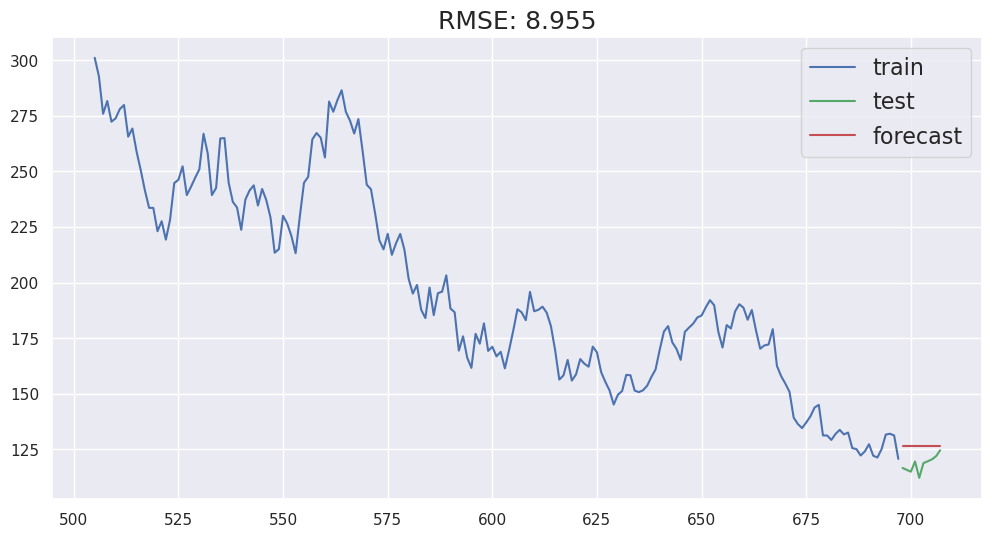

In [14]:
# LGBM
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster  
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
import lightgbm as lgb

def create_forecaster():
    regressor = lgb.LGBMRegressor()
    # wraps LGBM to convert time series into tabular format
    # necessary to fit the forecaster 
    forecaster = make_reduction(regressor, window_length=5, strategy="recursive")
    return forecaster

# used to find the best window_length of lagged features
def grid_search_forecaster(train, test, forecaster, param_grid):
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")

    # forecasting
    fh = np.arange(len(test)) + 1
    y_pred = gscv.predict(fh=fh)
    rmse = plot_forecast(train, test, y_pred)

    return y_pred, rmse

param_grid = {"window_length": [5,10,15,20,25,30,35,40,45]}
forecaster = create_forecaster()
lgbm_y = df[df.Date > '2022-01-01'].y
lgbm_test_len = 10
lgbm_price_train, lgbm_price_test = lgbm_y.iloc[:-lgbm_test_len], lgbm_y.iloc[-lgbm_test_len:]
forecast, rmse = grid_search_forecaster(lgbm_price_train, lgbm_price_test, forecaster, param_grid)

best params: {'window_length': 5}


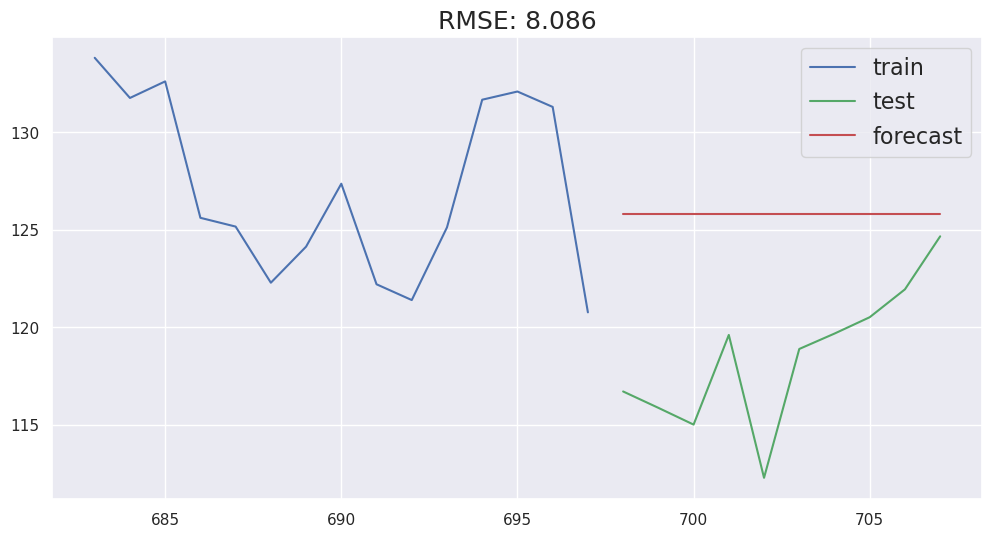

best params: {'window_length': 5}


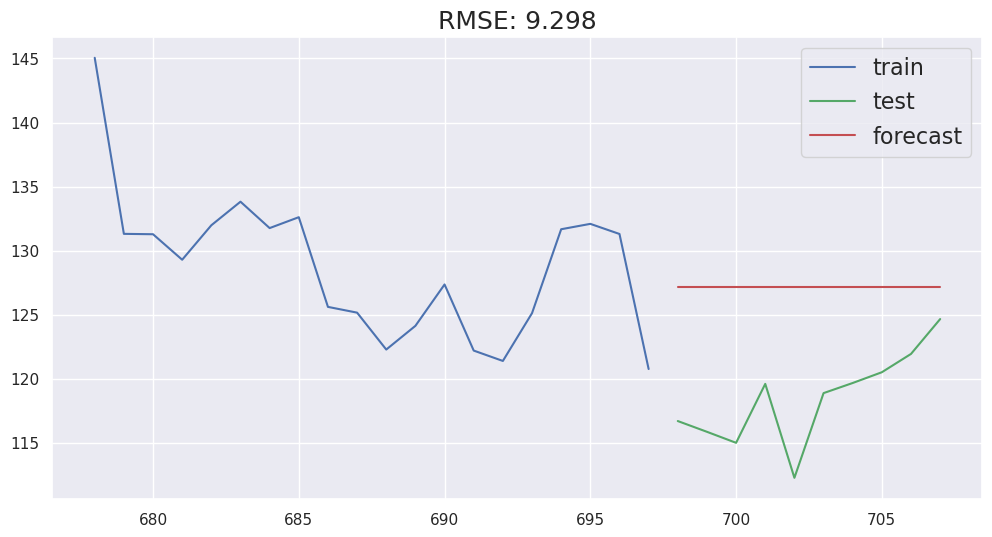

best params: {'window_length': 10}


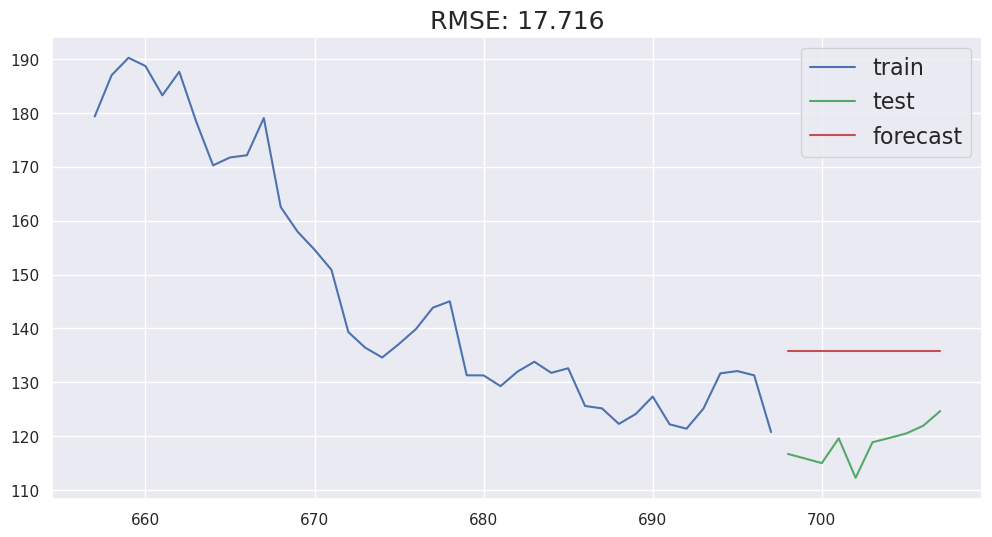

best params: {'window_length': 10}


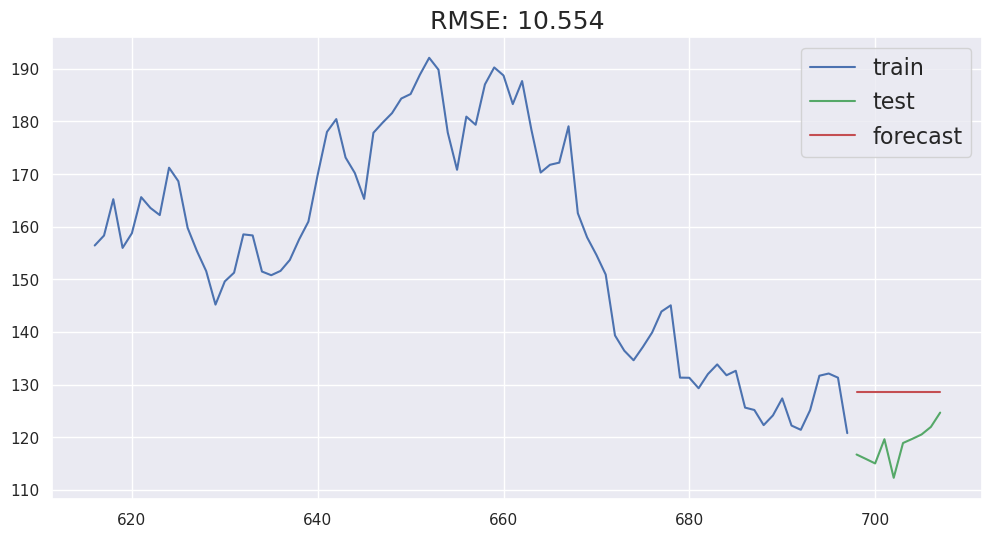

best params: {'window_length': 30}


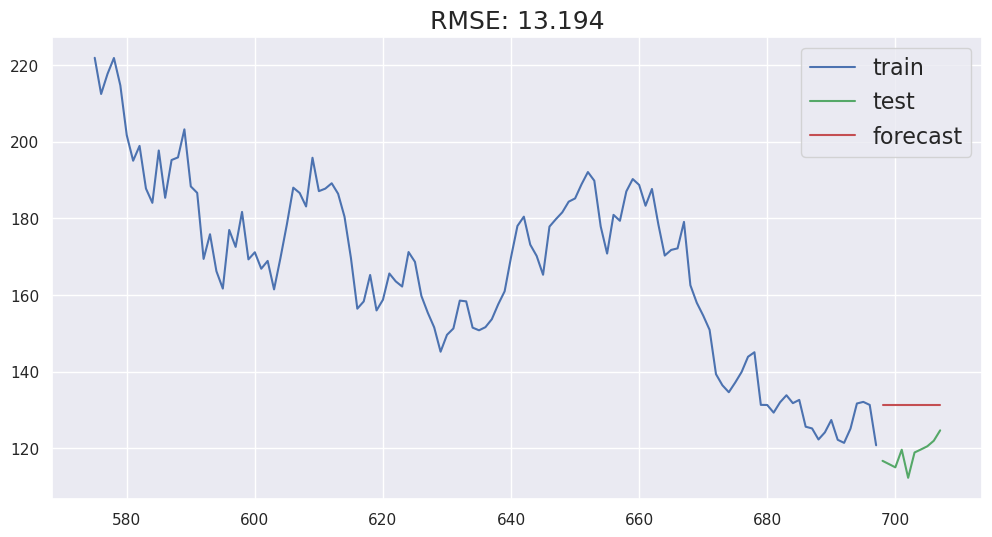

best params: {'window_length': 45}


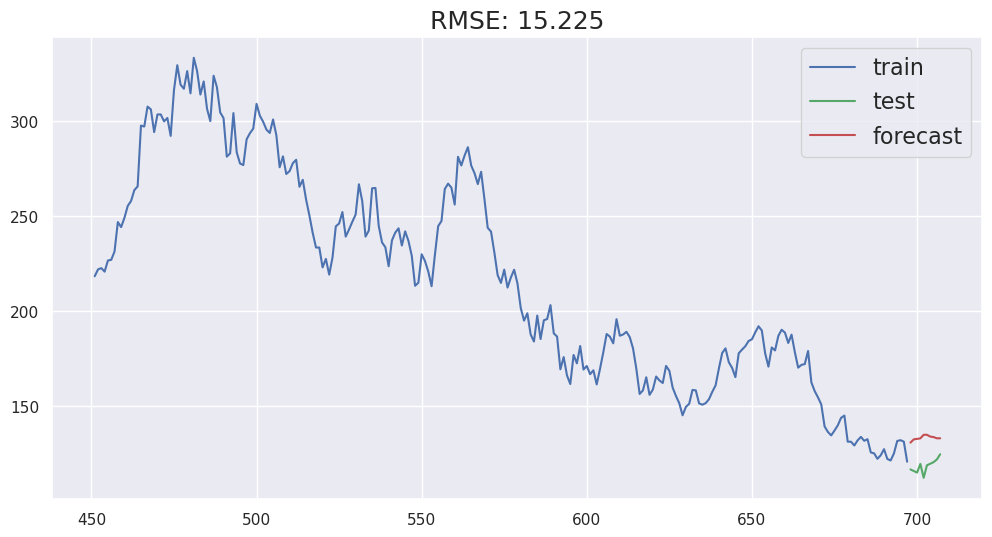

best params: {'window_length': 45}


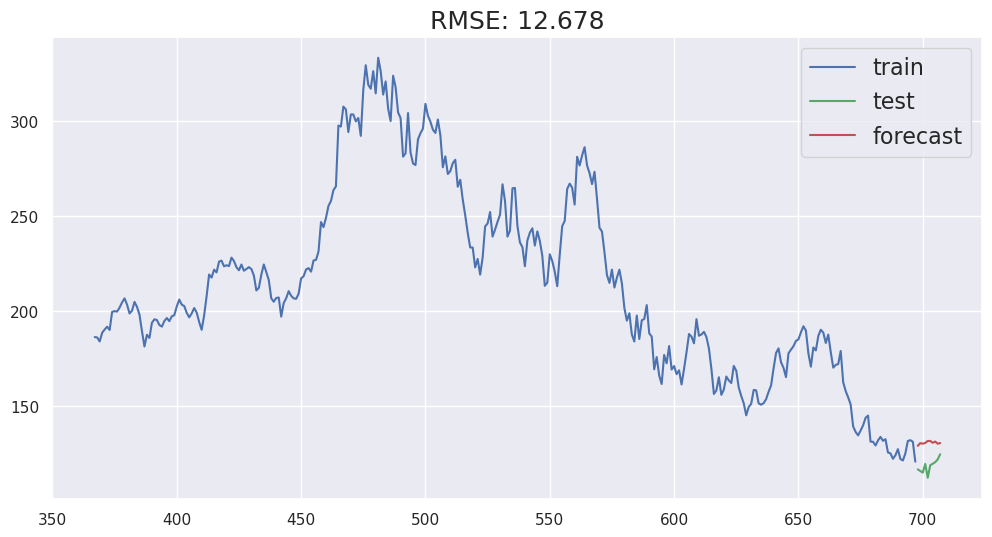

best params: {'window_length': 40}


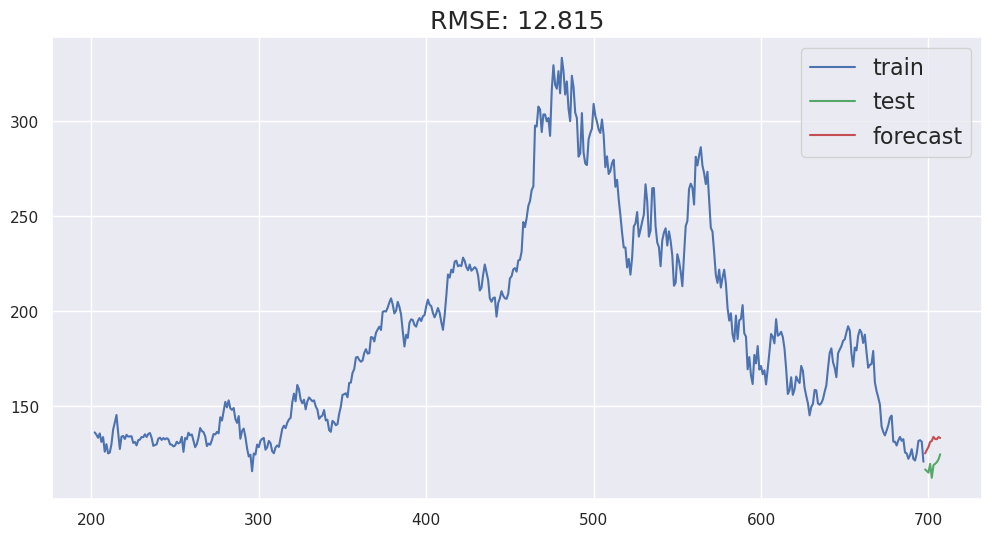

In [15]:
# Examine fitting model to different lookback period to predict T+14 Closing Price

lookback_periods = [21,28,60,120,180,360,480,720]
forecaster = create_forecaster()

from datetime import date, timedelta

rmse_dict = {}
main_param_grid = {"window_length": [5,10,15,20,25,30,35,40,45]}

for lookback in lookback_periods:
    lookback_date = pd.to_datetime(date.today() - timedelta(days=(lookback + 14)))
    lgbm_y = df[df.Date > lookback_date].y

    lgbm_test_len = 10
    param_grid = {"window_length": [x for x in main_param_grid["window_length"] if x*4 < lookback]}

    lgbm_price_train, lgbm_price_test = lgbm_y.iloc[:-lgbm_test_len], lgbm_y.iloc[-lgbm_test_len:]
    forecast, rmse = grid_search_forecaster(lgbm_price_train, lgbm_price_test, forecaster, param_grid)
    rmse_dict[lookback] = rmse

## Results from Backtesting LGBM 

As LGBM only predicts forecasts in one-step intervals, the predicted value is used to generate features in the next step. This occurs during multi-step forecasting.

Similar to the ARIMA model, RMSE is lowest when fit to short-term and highest when fit to medium- to long-term data. From the forecasts produced by fitting short-term data, we observe that the forecasts over 14 days share the same price. 

On the other hand, LGBM models fed with longer-term data tend to use longer window lengths to forecast future prices. While using longer window lengths could possibly account for longer-term trends, it fails to predict shorter-term prices.

In all cases, our LGBM model performs worse than a naive forecast. 